# Computer Vision

## Image Augmentation

图像增强可以由以下事实激发：对训练示例的随机调整使模型对某些属性的依赖性降低，从而提高了它们的泛化能力。  
例如，我们可以以不同的方式裁剪图像，使感兴趣的对象出现在不同的位置，从而减少模型对对象位置的依赖。我们还可以调整亮度、颜色等因素，以降低模型对颜色的敏感性。

数据增强方式：  
1. 训练时跨图片增强方式： 1. Mixup 2. CutMix 3. Monica   
2. 测试时图片增强方式: 在图片推理时使用增强，预测结果最终为增强图片的平均预测结果  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411252117272.png" height= '350px' width='600px' >
</div> 

显著性拼接增强  Saliencymix  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411252120977.png" height= '350px' width='600px' >
</div> 

Co-Mixup  
Supermix  
Mainfold Mixup  隐藏特征层 mixup  
Alignmix  
TokenMixup  

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import dl2_torch as d2l
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch.nn.functional as F

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 170498071/170498071 [00:15<00:00, 11295566.08it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


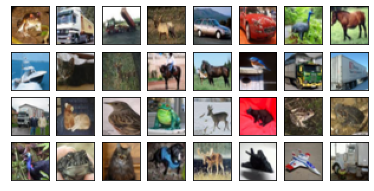

In [3]:
all_images = torchvision.datasets.CIFAR10(train=True, root="./data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [2]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="./data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [3]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [4]:
batch_size, devices, net = 2, d2l.try_all_gpus(), d2l.resnet18(10, 3)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

d:\Anaconda3\envs\data_torch\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [6]:
train_with_data_aug(train_augs, test_augs, net)

Files already downloaded and verified
Files already downloaded and verified


: 

## Fine-Tuning

- 目标模型复制源模型的所有模型设计及其参数，除了输出层，并基于目标数据集对这些参数进行微调。相比之下，目标模型的输出层需要从头开始训练。
- 一般来说，微调参数使用较小的学习率，而从头开始训练输出层可以使用较大的学习率。  

Torch 为不同参数组设置不同大小的学习率
```python  
optimizer = optim.SGD([
    {'params': model.fc1.parameters(), 'lr': 0.01},
    {'params': model.fc2.parameters(), 'lr': 0.001}
], momentum=0.9)



#  微调设定不同参数的学习率
params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
```

## Object Detection

1. 我们在图像的每个像素上生成不同形状的中心锚框。
2. 交并比（IoU），也称为 Jaccard 指数，衡量两个边界框的相似度。它是它们交集面积与并集面积的比率。
3. 在一个训练集中，我们需要为每个锚框提供两种类型的标签。一种是与锚框相关的**对象类别**，另一种是**真实边界框相对于锚框的偏移量**。
4. 在预测过程中，我们可以使用非极大值抑制（NMS）来去除相似的预测边界框，从而简化输出。


- 一类目标检测算法基于错框来预测
- 首先生成大量框，并赋予标号，每个锚框作为一个样本进行训练
- 在预测时，使用 NMS 来去掉冗余的预测



### 1. Bounding Boxes

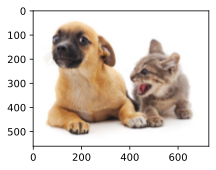

In [4]:
d2l.set_figsize()
img = plt.imread('./data/img/catdog.jpg')
plt.imshow(img)

在目标检测中，我们通常使用边界框来描述物体的空间位置。边界框是矩形的，由矩形左上角的 xy 坐标以及右下角的相应坐标确定。   
另一种常用的边界框表示方法是边界框中心的 (x,y) 轴坐标以及框的宽度和高度。

In [5]:
#  两种表示转换
#@save
def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [6]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

在图像中绘制框线

In [7]:
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (upper-left x, upper-left y, lower-right x,
    # lower-right y) format to the matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

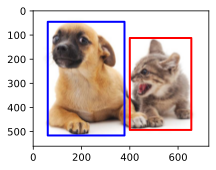

In [8]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))  # 在已有fig对象中绘制额外内容
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

### 2. Anchor Boxes  
每个锚框就是一个训练样本，训练时每个锚框要么标注成背景，要么关联一个真实边缘框，我们可能会生成大量的锚框（会有相当多的负样本）  

https://d2l.ai/chapter_computer-vision/anchor.html  
锚框：每个像素上进行缩放与调整宽高比后，得到的矩形框能否覆盖想要的物体。  
设缩放比例s (0, 1], 宽高比为r > 0, 则锚框的宽度和高度分别为 $ ws\sqrt{r}、 hs/\sqrt{r}$。总共会有
为了生成具有不同形状的多个锚框，我们设定一系列尺度 s1,…,sn 和一系列纵横比 r1,…,rm 。当使用这些尺度和纵横比的所有组合，以每个像素为中心时，输入图像将总共拥有 whnm 个锚框。  
尽管这些锚框可能覆盖所有真实边界框，但计算复杂度可能过高。在实践中，我们只能考虑包含 s1 或 r1 的组合：$ (s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1). $   
也就是说，以相同像素为中心的锚框数量为 n+m−1 。对于整个输入图像，我们将生成总共 wh(n+m−1) 个锚框

In [9]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')  # 生成网格坐标，shift_y 表示center_h 对应坐标值， shift_x同理， shift_y 与 shift_x 的组合即为生成的表格结果。
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 后续计算时 W = w * in_width = s * sqrt(r) * in_height, H = h * in_height = s / sqrt(r) * in_height , 保持宽高比为需要的值
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [10]:
#  绘制锚框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [11]:
img = d2l.plt.imread('./data/img/catdog.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape


561 728


torch.Size([1, 2042040, 4])

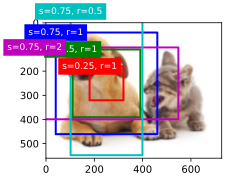

In [12]:
d2l.set_figsize()
boxes = Y.reshape(h, w, 5, 4)
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

### 3. Intersection over Union 交集面积比(IoU)  
$ J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}. $  



In [13]:
#  计算成对边框的交并比
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # None 用于增加维度用于后续广播  生成 (no. of boxes1, no. of boxes2, 2) 尺寸的矩阵
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

### 4. 训练数据中标注锚框  


#### 4.1 真实边界框分配给锚框  
即为每个训练样本（锚框）分配label（真实边框，包括框中的样本类别及边框需要变化的值）

让我们用一个具体例子来说明上述算法。如图 14.4.2（左）所示，假设矩阵 X 中的最大值为 x23 ，我们将真实边界框 B3 分配给锚框 A2 。然后，我们丢弃矩阵的第 2 行和第 3 列的所有元素，在剩余元素（阴影区域）中找到最大的 x71 ，并将真实边界框 B1 分配给锚框 A7 。接下来，如图 14.4.2（中）所示，丢弃矩阵的第 7 行和第 1 列的所有元素，在剩余元素（阴影区域）中找到最大的 x54 ，并将真实边界框 B4 分配给锚框 A5 。最后，如图 14.4.2（右）所示，丢弃矩阵的第 5 行和第 4 列的所有元素，在剩余元素（阴影区域）中找到最大的 x92 ，并将真实边界框 B2 分配给锚框 A9 。之后，我们只需要遍历剩余的锚框 A1,A3,A4,A6,A8 ，并根据阈值确定是否将它们分配真实边界框。


<div style="text-align: center;">
  <img src="https://imgbed.momodel.cn/202410141724848.png" width='600px' >
</div>


In [14]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)  # 找到每个 锚框 最相符的真实框，然后按照上述算法从最大真实框递减分配
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()  # 找到对应的 anchors 及 label 列所在的元素
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### 5. 锚框类别标签及偏移量

现在我们可以为每个锚框标注类别和偏移量。假设锚框 A 被分配了一个真实边界框 B 。一方面，锚框 A 的类别将被标注为 B 的类别。另一方面，锚框 A 的偏移量将根据 B 和 A 的中心坐标之间的相对位置以及这两个框的相对大小进行标注。考虑到数据集中不同框的位置和尺寸的变化，我们可以应用变换到这些相对位置和尺寸，**以获得更均匀分布的偏移量，这些偏移量更容易拟合**。在这里，我们描述一种常见的变换。给定 A 和 B 的中心坐标为 (xa,ya) 和 (xb,yb) ，它们的宽度为 wa 和 wb ，高度分别为 ha 和 hb ，我们可以将 A 的偏移量标注为：  
$$ \left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right) $$  
$ \mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1, \sigma_w=\sigma_h=0.2$

In [15]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为“背景”。  
类别为背景的锚框通常被称为负锚框，其余的称为正锚框。  
我们实现以下 multibox_target 函数，使用真实边界框（ labels 参数）为锚框（ anchors 参数）标记类别和偏移量。此函数将背景类别设置为零，并将新类别的整数索引加一。

In [16]:
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1  # 将与 anchor 配对好的真实框中的 class 赋值给该 anchor
        assigned_bb[indices_true] = label[bb_idx, 1:]  # 将与 anchor 配对好的真实框中的 框位置 赋值给该 anchor
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask  # 计算 anchor 与其对应的真实框的偏移量 offset 将背景锚框的偏移值设定为 0 
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

#### 测试

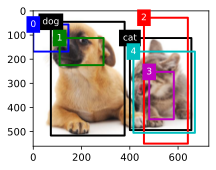

In [17]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [18]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

In [19]:
labels  # 每个锚框的类别

(tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
           1.0000e+01,  2.5940e+00,  7.1754e+00, -1.2000e+00,  2.6882e-01,
           1.6824e+00, -1.5655e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -5.7143e-01, -1.0000e+00,  4.1723e-06,  6.2582e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

锚框类别计算分析：  
让我们根据图像中锚框和真实边界框的位置来分析返回的类别标签。首先，在所有锚框和真实边界框的配对中，锚框 A4 和猫的真实边界框的 IoU 最大。因此， A4 的类别被标记为猫。移除包含 A4 或猫的真实边界框的配对后，剩下的配对中，锚框 A1 和狗的真实边界框的 IoU 最大。所以 A1 的类别被标记为狗。接下来，我们需要遍历剩余的三个未标记的锚框： A0 、 A2 和 A3 。对于 A0 ，与真实边界框 IoU 最大的类别是狗，但 IoU 低于预定义的阈值（0.5），因此类别被标记为背景；对于 A2 ，与真实边界框 IoU 最大的类别是猫，且 IoU 超过阈值，因此类别被标记为猫；对于 A3 ，与真实边界框 IoU 最大的类别是猫，但值低于阈值，因此类别被标记为背景。  

使用 mask 掩码覆盖去除背景类别对 **目标函数** 计算的影响   

第一个返回项包含每个锚框标记的四个偏移值。请注意，负类锚框的偏移值标记为零。

### 6.使用非极大值抑制（ Non-Maximum Suppression）预测边界框

通过锚框位置 及 对应的偏移量大小，计算预测框位置。

In [20]:
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]  # 逆变换为预测框的 x， y
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]  # 逆变换为预测框的 w， h
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox  # 返回预测的 两点形式的框

In [21]:
# 按降序排列置信度分数并返回它们的索引。
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]  # 由于 box_iou 是从 0开始索引，因此需要+1
    return torch.tensor(keep, device=boxes.device)

multibox_detection 应用于预测边界框的非极大值抑制

In [22]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))  # sort
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]  # sort
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]  # sort

        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        #  将概率太小的锚框标为背景框
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

在实践操作中，我们可以在执行非极大值抑制之前，移除预测置信度较低的边界框，从而减少该算法的计算量。  
我们还可以对非极大值抑制的输出进行后处理，例如，只保留最终输出中置信度较高的结果。  
可以将所有类放在一起进行nms， 也可以分类别进行nms。  

#### 测试  
筛选以下锚框， 仅预留最合适的目标框

In [23]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood
                      [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted cat likelihood

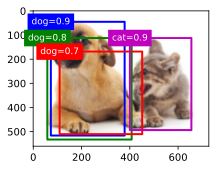

In [24]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [25]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)

In [26]:
output  # 类别， conf， 预测框两点坐标

tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100]]])

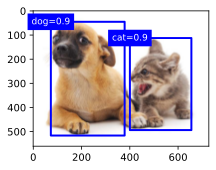

In [27]:
#  绘制 label != -1 的框
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

## 7. 多尺度锚框生成

- 在多个尺度上，我们可以生成不同大小的锚框以检测不同大小的物体。  
- 通过定义特征图 （fmap_w, fmap_h） 的形状，我们可以在任何图像上确定均匀采样锚框的中心。
- 我们使用输入图像中某个感受野的信息来预测靠近该感受野的锚框在输入图像中的类别和偏移量。
- 通过深度学习，我们可以利用其在多个层次上对图像的分层表示来进行多尺度目标检测。


我们只需从输入图像中均匀地采样一小部分像素来生成以这些像素为中心的锚框。此外，在不同尺度上，我们可以生成不同数量和尺寸的锚框。  
直观上，较小的物体比较大的物体更有可能在图像中出现。例如， 1×1 、 1×2 和 2×2 物体可以在 2×2 图像中以 4、2 和 1 种可能的方式出现。  
因此，当使用较小的锚框检测较小的物体时，我们可以采样更多区域，而对于较大的物体，我们可以采样较少区域。

In [28]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = torch.tensor((w, h, w, h))  # 按照原始图片大小生成相应位置的锚框
    d2l.show_bboxes(d2l.plt.imshow(img).axes,
                    anchors[0] * bbox_scale)

在不同像素上生成不同比例的锚框， 以下为生成 4 * 4 个锚框， 通过比例在图片上缩放到对应的位置， s 比例小用以检测小物体， s 大比例用以检测大物体

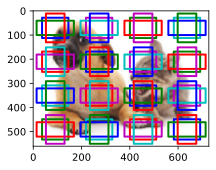

In [29]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

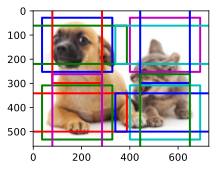

In [30]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

## 8.目标检测数据集

香蕉数据集： 图像小批量的形状为（批量大小，通道数，高度，宽度），看起来很熟悉：它与我们在之前的图像分类任务中使用的形状相同。  
标签小批量的形状为（批量大小， m，5），其中 m 是数据集中任何图像可能具有的最大边界框数量（或者说是该图片中包含的物体个数， 如果图片物体多于m个，怎抛弃多余的使其对应dim值为m）。  

一般来说，图像可能包含不同数量的边界框；因此，边界框数量少于 m 的图像将通过填充非法边界框直到达到 m 。  
然后，每个边界框的标签由长度为 5 的数组表示。数组中的第一个元素是边界框中对象的类别，其中-1 表示用于填充的非法边界框。  
数组的其余四个元素是边界框左上角和右下角的( x , y )坐标值（范围在 0 到 1 之间）。对于香蕉数据集，由于每张图像上只有一个边界框，我们得到 m=1 。

下载数据集

In [39]:
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256  # 用于将位置点位归一化为 [0, 1] 区间

构建数据集

In [33]:
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

定义 DataLoader

In [34]:
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

#### 测试

In [37]:
batch_size, edge_size = 8, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([8, 3, 256, 256]), torch.Size([8, 1, 5]))

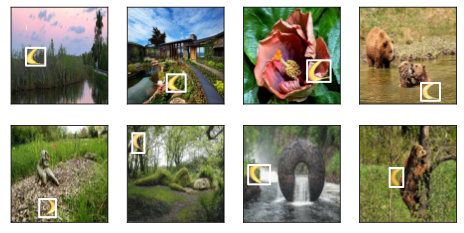

In [42]:
imgs = (batch[0][:8].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 4, scale=2)
for ax, label in zip(axes, batch[1][:8]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

# 目标检测 - Single Shot Multibox detection(SSD)  单次多框检测

SSD 模型结构如下  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202410161101642.png" width='800px' >
</div>   

多尺度特征图：在CNN语境下即不同层次的特征图， ImageNet 为不同层的特征输出。   

### 1. 类别预测层

特征图的每个空间位置为中心生成 a 个锚框时，总共需要分类 hwa 个锚框， 假设共有 q 个class （包含背景则为 q + 1）。  

具体来说，类别预测层使用一个卷积层，不改变特征图的宽度和高度。这样，输出和输入在特征图相同的空间维度（宽度和高度）上可以有一一对应的关系。  
更具体地说，任何空间位置（ x ， y ）的输出特征图通道代表输入特征图上以（ x ， y ）为中心的所有锚框的类别预测。  
为了产生有效的预测，必须有 a(q+1) 个输出通道，其中对于相同的空间位置，索引为 i(q+1)+j 的输出通道代表锚框 i （ 0≤i< a ）的类别 j （ 0≤j≤q ）的预测。

In [43]:
#  以下我们定义这样一个类别预测层，通过参数 `num_anchors` 和 `num_classes` 分别指定 a 和 q 。该层使用一个填充为 1 的 3×3 卷积层。该卷积层的输入和输出宽度和高度保持不变。

def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

### 2. 边界框预测层

边界框预测层的结构设计与类别预测层相似。唯一的区别在于每个锚框的输出数量：这里我们需要预测四个偏移量，而不是 q + 1 个类别。

In [44]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

### 3. 多尺度预测的拼接

以下示例中，我们对同一 minibatch 构建了两个不同尺度的特征图， `Y1` 和 `Y2` ，其中 `Y2` 的高度和宽度是 `Y1` 的一半。以类别预测为例。  
假设在 `Y1` 和 `Y2` 的每个单元中分别生成了 5 个和 3 个锚框。进一步假设物体类别数为 10。  
对于特征图 `Y1` 和 `Y2` ，类别预测输出的通道数分别为 5×(10+1)=55 和 3×(10+1)=33 ，其中任一输出形状为（批大小，通道数，高度，宽度）。

In [45]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

如我们所见，除了批量大小维度外，其他三个维度大小都不同。为了更高效地进行计算，我们将这些张量转换成更一致的形式，以连接这两个预测输出。  

通道维度包含具有相同中心的锚框的预测。我们首先将此维度移动到最内层。由于不同尺度下的批处理大小保持不变，我们可以将预测输出转换为一个形状为（批处理大小，高度 × 宽度 × 通道数）的二维张量。  
然后我们可以沿着维度 1 将不同尺度的此类输出连接起来。


In [46]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)


In [47]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### 4. 下采样模块  

下方定义的下采样模块， 在输出的每个像素上均有  1×2+(3−1)+(3−1)=6 ， 即 6 * 6 的感受野。

In [48]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [49]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

### 5. 基础网络模块  
用于调整图像大小及前期的预处理工作  

In [50]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

### 6. 完整模型  
每个模块产生的特征图既用于（i）生成锚框，也用于（ii）预测这些锚框的类别和偏移量。  
在这五个模块中，第一个是基础网络模块，第二个到第四个是下采样模块，最后一个模块使用全局最大池化将高度和宽度都减少到 1。  
技术上讲，第二个到第五个模块都是图 14.7.1 中的**多尺度特征图模块**。

In [56]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

推理过程

In [63]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes=size, ratios=ratio)  # 1, num_anchors * H * W， 4
    cls_preds = cls_predictor(Y)  # batch_size, num_anchors * （num_classes + 1）， H， W
    bbox_preds = bbox_predictor(Y)  # batch_size, num_anchors * 4, H, W
    return (Y, anchors, cls_preds, bbox_preds)

每个尺度图对应的 size（缩放） 及 ratio（宽高比）设定。  
通过等分及计算区间的几何平均数确定每个尺寸的缩放比例。

In [51]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

TinySSD

In [53]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)  # 1, all_num_anchors, 4， 所有样本都是相同的锚框，首个维度为1
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)  # batch_size, all_num_anchors, num_classes
        bbox_preds = concat_preds(bbox_preds)  # batch_size, all_num_anchors * 4
        return anchors, cls_preds, bbox_preds

我们创建一个模型实例，并使用它对一组 256×256 图像 `X` 进行前向传播。  
第一个块输出 32×32 特征图。回想一下，第二到第四个下采样块将高度和宽度减半，第五个块使用全局池化。  
由于每个特征图的空间维度上为每个单元生成 4 个锚框，因此在所有五个尺度上，每个图像总共生成 (322+162+82+42+1)×4=5444 个锚框。

In [66]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)  # 预测的边框按照最后一个维度进行聚合

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## Train

In [67]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

### 损失函数  
目标检测有两种损失类型。第一种损失关注锚框的类别：其计算可以简单地重用我们用于图像分类的交叉熵损失函数。  
第二种损失关注正（非背景）锚框的偏移量：这是一个回归问题。然而，对于这个回归问题，我们在此不使用第 3.1.3 节中描述的平方损失。  
相反，我们使用 ℓ1 范数损失，即预测值与真实值之间差异的绝对值。掩码变量 `bbox_masks` 在损失计算中过滤掉负锚框和非法（填充）锚框。最后，我们将锚框类别损失和锚框偏移量损失相加，以获得模型的损失函数。



In [68]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [69]:
def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

###  训练模型

class err 1.79e-03, bbox mae 1.83e-03
3947.3 examples/sec on cuda:0


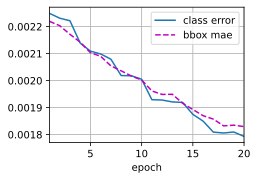

In [72]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # Sum of training accuracy, no. of examples in sum of training accuracy,
    # Sum of absolute error, no. of examples in sum of absolute error
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # Generate multiscale anchor boxes and predict their classes and
        # offsets
        anchors, cls_preds, bbox_preds = net(X)
        # Label the classes and offsets of these anchor boxes
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)  # 将随机生成的 anchors 转换为真实的目标框
        # Calculate the loss function using the predicted and labeled values
        # of the classes and offsets
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,  # bbox_labels 中是 anchor 与 对应真实框的偏移量
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

## Predict

In [76]:
X = torchvision.io.read_image('./data/img/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

使用下面的 multibox_detection 函数，从锚框及其预测偏移量中获取预测的边界框。然后使用非极大值抑制来去除相似的预测边界框。

In [80]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = multibox_detection(cls_probs, bbox_preds, anchors)  # 对预测结果使用非极大值抑制 NMS 
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

In [86]:
output = predict(X)

最后，我们将置信度达到 0.9 或以上的所有预测边界框作为输出显示。

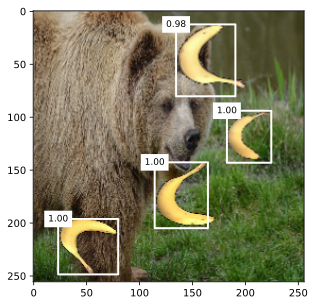

In [88]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

## 小结
- 单次多框检测是一种多尺度目标检测模型。通过其基础网络和多个多尺度特征图块，单次多框检测生成不同尺寸的锚框，并通过预测这些锚框的类别和偏移量（从而是边界框）来检测不同大小的对象。
- 在训练单次多框检测模型时，损失函数是根据锚框类别的预测值和标签值以及偏移量来计算的。

# 目标检测 - Region-based CNNs(R-CNNS) 区域卷积神经网络  

另一种锚框型目标检测模型，通过预选框及提取框内图像特征，预测框内物体类别及与真实框的偏移量。  
https://d2l.ai/chapter_computer-vision/rcnn.html

## ROI 感兴趣区域池化（ region of interest）
即将不同大小的锚框池化为相同尺寸大小，方便将不同的框拼接为统一 batch  进行后续处理。  
关键点在于非整除像素的处理   

主要模型：  
- R-CNN 从输入图像中提取许多区域提议，使用 CNN 对每个区域提议进行前向传播以提取其特征，然后使用这些特征来预测该区域提议的类别和边界框。  
- 快速 R-CNN 相较于 R-CNN 的主要改进之一是 CNN 前向传播仅在整张图像上执行。它还引入了感兴趣区域池化层，以便可以从不同形状的感兴趣区域中进一步提取相同形状的特征。
- R-CNN 快速算法用联合训练的区域提议网络替换了在快速 R-CNN 中使用的选择性搜索，从而使前者在减少区域提议数量的同时保持目标检测的准确性。
- 基于更快的 R-CNN，mask R-CNN 额外引入了一个全卷积网络，以便利用像素级标签进一步提高目标检测的准确性。

In [2]:
X = torch.arange(16.).reshape(1, 1, 4, 4)   # 特征图片
rois = torch.Tensor([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])  # 感兴趣的选择框  
torchvision.ops.roi_pool(X, rois, output_size=(2, 2), spatial_scale=0.1)  # 选择框对应的池化输出

tensor([[[[ 5.,  6.],
          [ 9., 10.]]],


        [[[ 9., 11.],
          [13., 15.]]]])

# 语义分割

## 1. 数据读取

In [12]:
# d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
#                            '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir = './data/VOCdevkit/VOC2012'

In [10]:
def read_voc_images(voc_dir, is_train=True):
    """Read all VOC feature and label images."""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    features, labels = [], []
    for i, fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode))
    return features, labels

train_features, train_labels = read_voc_images(voc_dir, True)

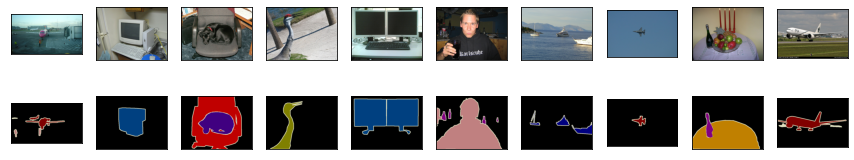

In [11]:
n = 10
imgs = train_features[:n] + train_labels[:n]
imgs = [img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs, 2, n);

### 绘制图片像素映射

In [13]:
#@save
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

#@save
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [14]:
#@save
def voc_colormap2label():
    """Build the mapping from RGB to class indices for VOC labels."""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

#@save
def voc_label_indices(colormap, colormap2label):
    """Map any RGB values in VOC labels to their class indices."""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [16]:
y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]  # 将图片的像素转换为标签

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

### 随即裁剪

1. 改变图片大小的处理方式存在反向映射的困难

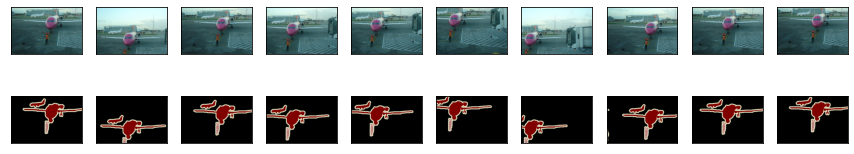

In [17]:
#@save
def voc_rand_crop(feature, label, height, width):
    """Randomly crop both feature and label images."""
    rect = torchvision.transforms.RandomCrop.get_params(
        feature, (height, width))
    feature = torchvision.transforms.functional.crop(feature, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

### 自定义语义分割数据集类 

In [19]:
class VOCSegDataset(torch.utils.data.Dataset):
    """A customized dataset to load the VOC dataset."""

    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    def filter(self, imgs):  #  过滤掉原始尺寸小于待裁剪尺寸的图片
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.features)

In [20]:
batch_size = 32
crop_size = (320, 480)

train_iter = torch.utils.data.DataLoader(VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True, drop_last=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True, num_workers=0)

read 1114 examples
read 1078 examples


## 2. 转置卷积 Transposed Convolution

转置卷积有多种方式，以下为其中一种。  

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202410291011377.png" width='600px' >
</div>

padding 参数： 输出在h，w方向上减少padding行  
stride： 同步长  
通道： 同普通卷积

其他方式例如在输入周围padding多层，然后用传统卷积计算方式达到上采样目的(主观上感觉没有上面这种好)  
上采样可用于将模型**中间特征**恢复为原始特征图的尺寸，观察中间特征数据。  

另一种理解方式： 转置卷积是一种变化了输入和核的卷积，来得到上采用的目的， 不等同于数学上的反卷积操作  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411082311623.png" width='600px' >
</div>

In [21]:
def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

In [23]:
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)


tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [25]:
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

### 与转置矩阵关联  
通过将卷积矩阵转置，即可得到反卷积的计算结果  


``` python
将 K = torch.tensor([[1.0, 2.0], [3.0, 4.0]]) 卷积核修改为如下矩阵形式
tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

该矩阵与输入数据相乘即得到卷积的效果。  
将其转置与输出相乘即可得到反卷积结果
```

In [26]:
X = torch.arange(9.0).reshape(3, 3)
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
Y = d2l.corr2d(X, K)
Y

tensor([[27., 37.],
        [57., 67.]])

In [27]:
def kernel2matrix(K):
    k, W = torch.zeros(5), torch.zeros((4, 9))
    k[:2], k[3:5] = K[0, :], K[1, :]
    W[0, :5], W[1, 1:6], W[2, 3:8], W[3, 4:] = k, k, k, k
    return W

W = kernel2matrix(K)
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

In [ ]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

In [28]:
Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)  # 卷积矩阵转置即可将结果矩阵返回为之前的矩阵

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

### 转置 shape 计算

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202411082312736.png" width='600px' >
</div>

重点在于如果想要尺寸成倍变化， 需要使得 k = 2p + s  可以算出需要的超参数

## 3. Fully Convolutional Networks   
即预测图片每个像素的label：  
- 全卷积网络首先使用卷积神经网络提取图像特征，然后通过一个 1×1 卷积层将通道数转换为类别数，最后通过转置卷积将特征图的宽度和高度转换为输入图像的宽度和高度。 
- 在完全卷积网络中，我们可以使用双线性插值的上采样来初始化转置卷积层。  

FCN 进化版本为 Unet

In [29]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

d:\Anaconda3\envs\data_torch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
d:\Anaconda3\envs\data_torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
#  仅提取特征提取部分层
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [33]:
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

### 转置卷积尺寸计算  
我们需要将特征图的高度和宽度增加 32 倍，以将其变回输入图像的高度和宽度。  
回忆第 7.3 节中如何计算卷积层的输出形状。由于 (320−64+16×2+32)/32=10 和 (480−64+16×2+32)/32=15 ，我们构建一个步长为 32 的转置卷积层，设置核的高度和宽度为 64 ，填充为 16 。  
- 一般来说，我们可以看到对于步长 s ，填充 s/2 （假设 s/2 是整数），以及核的高度和宽度为 2s ，转置卷积将输入的高度和宽度增加 s 倍。



In [34]:
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

### 初始化转置卷积-双线性插值  
在图像处理中，我们可能需要放大图像，即上采样。双线性插值是常用的上采样技术之一。  
为了解释双线性插值，可以说，给定一个输入图像，我们想要计算放大输出图像中的每个像素。为了计算输出图像在坐标 (x,y) 处的像素，首先将 (x,y) 映射到输入图像上的坐标 (x′,y′) ，例如，根据输入大小与输出大小的比例。注意，映射的 x′ 和 y′ 是实数。然后，找到输入图像上与坐标 (x′,y′) 最近的四个像素。最后，根据输入图像上这四个最近的像素及其与 (x′,y′) 的相对距离来计算输出图像在坐标 (x,y) 处的像素。

In [36]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [37]:
#  使用双线性插值初始化
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

```python
input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])  # 转置卷积将图片放大，但是整体内容没有修改
```

In [39]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);  # 使用copy_ 初始化

### 训练

loss 0.413, train acc 0.871, test acc 0.853
70.9 examples/sec on [device(type='cuda', index=0)]


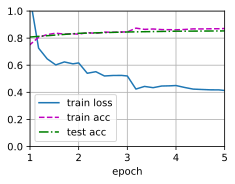

In [40]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

### 预测

在预测时，我们需要在每个通道中对输入图像进行标准化，并将图像转换为 CNN 所需的四维输入格式。

In [42]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

#  为了可视化每个像素预测的类别，我们将预测的类别映射回数据集中对应的标签颜色。
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

实际应用时需要注意图片大小是否可以整除等细节，此处直接裁剪相应尺寸测试。

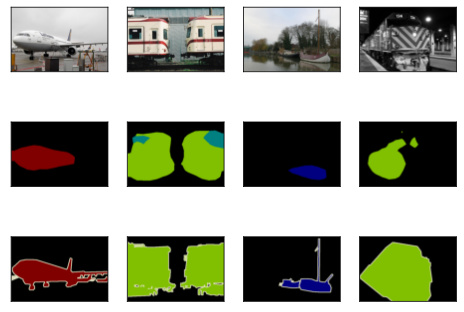

In [43]:
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

# 图像风格迁移

<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202410291422087.png" width='700px' >
</div>  

接下来，我们通过前向传播（实箭头方向）计算风格迁移的损失函数，并通过反向传播（虚箭头方向）更新模型参数（输出合成的图像）。  
在风格迁移中常用的损失函数包括三个部分：（i）内容损失使合成的图像和内容图像在内容特征上接近；（ii）风格损失使合成的图像和风格图像在风格特征上接近；（iii）总变差损失有助于减少合成的图像中的噪声。  
最后，当模型训练完成后，我们输出风格迁移的模型参数以生成最终的合成图像。

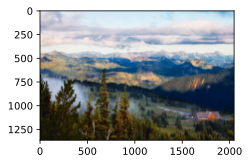

In [2]:
d2l.set_figsize()
content_img = d2l.Image.open('./data/rainier.jpg')
d2l.plt.imshow(content_img);

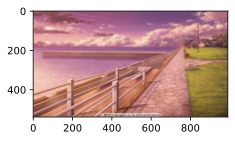

In [32]:
style_img = d2l.Image.open('./data/comic.jpg')
d2l.plt.imshow(style_img);

## 1. 数据预处理  
图片数据归一化，及输出值反向映射为图片像素

In [3]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

## 2. 特征提取  
使用VGG模型  
为了提取图像的内容特征和风格特征，我们可以选择 VGG 网络中某些层的输出。  
- 一般来说，越接近输入层，越容易提取图像的细节，反之，越容易提取图像的全局信息。  

为了避免在合成图像中过度保留内容图像的细节，我们选择一个靠近输出的 VGG 层作为内容层以输出图像的内容特征。  
我们还选择不同 VGG 层的输出以提取局部和全局风格特征。这些层也被称为风格层。如第 8.2 节所述，VGG 网络使用 5 个卷积块。  
在实验中，我们选择第四个卷积块的最后一个卷积层作为内容层，以及每个卷积块的第一个卷积层作为风格层。这些层的索引可以通过打印 pretrained_net 实例获得。

In [4]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

d:\Anaconda3\envs\data_torch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
d:\Anaconda3\envs\data_torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])  # 选取指定的特征层

In [6]:
#  计算指定层的输出

def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [7]:
#  提取内容图片 与 风格图片的指定内容

def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## 3. 损失函数

内容损失

In [8]:
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

风格损失

我们使用 gram 来表示风格层的风格输出  
gram 函数实际上是计算通道之间的协方差（二阶统计信息），使用该通道协方差矩阵作为图片的风格特征

In [ ]:
def gram(X):  # 使用 gram 计算风格图中每个channel 之间的相关性，作为该风格图的特征提取
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):  # 计算两个gram之间的距离
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

Total Variation Loss  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202410291809165.png" width='700px' >
</div>  

In [11]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

总损失函数  
三种损失之间的加权和， 多个损失的问题需要使用权重去平衡损失之间的量级

In [ ]:
content_weight, style_weight, tv_weight = 1, 1e4, 10  # 多个损失的问题需要使用权重去平衡损失之间的量级

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## 4.初始合成图像  
在风格迁移中，合成的图像是训练过程中唯一需要更新的变量。  
因此，我们可以定义一个简单的模型 SynthesizedImage ，并将合成的图像视为模型参数。在这个模型中，正向传播仅返回模型参数。

In [12]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [31]:
# 初始化合成图像
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer  # gen_img() 返回对应的参数

## 5. 训练

In [22]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    print(X)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

现在我们开始训练模型。我们将内容和风格图像的高度和宽度重缩放为 300×450 像素。我们使用内容图像来初始化合成的图像。

In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

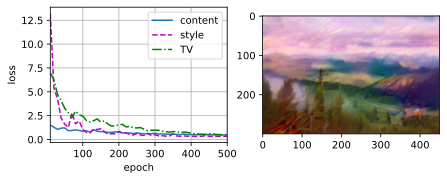

In [33]:
device, image_shape = d2l.try_gpu(), (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)